# DS6003: Pipeline Assignment
### Ab Boxley, asb4rf

## 1. Create context

In [2]:
#Load libraries
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [3]:
#Create context
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

## 2. Data preparation

In [26]:
#Data: http://opendata.charlottesville.org/datasets/real-estate-residential-details/data
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'asb4rf/cville_res_real_estate.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
#pd.read_csv(data_location) #Pandas can read directly from and S3 bucket
    #But you need permissions - Works here because it's wired into SageMaker
    
#Create a sql context DF from a pandas DF
    #Keep in mind the sqlc is lazy but the read_csv is evaluated and it will not
    #work on big files
pddf = pd.read_csv(data_location)
pddf.shape

(14516, 24)

In [27]:
pddf.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RecordID_Int,14516,NaN,NaN,NaN,7262.6,4192.46,1,3632.75,7262.5,10893.2,14522
ParcelNumber,14516,14174,570157008,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StreetNumber,14478,2000,0,685,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StreetName,14516,586,JEFFERSON PARK AVE,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unit,1545,584,A&B,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UseCode,14514,50,Single Family,8277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Style,13313,31,1 Story,5662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Grade,13311,20,C,5689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Roof,13240,12,Shingles,9246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flooring,13312,15,Hardwood,9933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
pddf.dtypes

RecordID_Int                     int64
ParcelNumber                    object
StreetNumber                    object
StreetName                      object
Unit                            object
UseCode                         object
Style                           object
Grade                           object
Roof                            object
Flooring                        object
Heating                         object
Fireplace                       object
YearBuilt                      float64
TotalRooms                      object
Bedrooms                        object
HalfBathrooms                   object
FullBathrooms                   object
BasementGarage                  object
Basement                       float64
FinishedBasement               float64
BasementType                    object
ExternalWalls                   object
NumberOfStories                 object
SquareFootageFinishedLiving    float64
dtype: object

In [28]:
#Try dropping NAs
pddf.dropna().shape

(96, 24)

In [67]:
#Dropping NAs is too draconian, let's try limiting to the columns we'll use
pddf_ = pddf.loc[:, ["YearBuilt","SquareFootageFinishedLiving", "Basement", "FinishedBasement"]].dropna()
#pddf = pddf.loc[:, ["YearBuilt","SquareFootageFinishedLiving","NumberOfStories"]].dropna()
pddf_.shape

(9341, 4)

In [68]:
#pddf[["a", "b"]] =
#pddf[["TotalRooms", "Bedrooms"]].apply(pd.to_numeric).dtypes

In [69]:
#Remove year built before 1600
pddf_ = pddf_[pddf['YearBuilt']>1600].reset_index()
pddf_.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(9320, 5)

In [70]:
#Covert to sql df (because pyarrow is not available to write to parquet)
df = sqlc.createDataFrame(pddf_)
print(df.take(2))

[Row(index=0, YearBuilt=1967.0, SquareFootageFinishedLiving=1518.0, Basement=1518.0, FinishedBasement=759.0), Row(index=1, YearBuilt=1966.0, SquareFootageFinishedLiving=1138.0, Basement=1163.0, FinishedBasement=540.0)]


In [71]:
#Export to parquet
parquet_path = '/home/ec2-user/SageMaker/Open-Data-Lab/education/Spark19SpDS6003-001/asb4rf/asb4rf_pipeline_exercise/df_parquet'
df.write.parquet(parquet_path, mode = "overwrite")

In [72]:
#Read back in parquet
dat = sqlc.read.parquet(parquet_path)
dat

DataFrame[index: bigint, YearBuilt: double, SquareFootageFinishedLiving: double, Basement: double, FinishedBasement: double]

## 3. MLlib based analysis
### Predicting home size

In [73]:
#Peep the fields
dat.printSchema()

root
 |-- index: long (nullable = true)
 |-- YearBuilt: double (nullable = true)
 |-- SquareFootageFinishedLiving: double (nullable = true)
 |-- Basement: double (nullable = true)
 |-- FinishedBasement: double (nullable = true)



In [74]:
# create train/test sets
seed = 99
(testDF, trainingDF) = dat.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 7458, test set N = 1862


In [75]:
from pyspark.ml.linalg import Vectors, VectorUDT

In [76]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("SquareFootageFinishedLiving", "oneElementVec(YearBuilt) as YearBuilt")
testDF = testDF.selectExpr("SquareFootageFinishedLiving", "oneElementVec(YearBuilt) as YearBuilt")



In [77]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("SquareFootageFinishedLiving", "label")\
    .withColumnRenamed("YearBuilt", "features")
#    .withColumnRenamed(["YearBuilt", "NumberOfStories"], "features")
testDF = testDF.withColumnRenamed("SquareFootageFinishedLiving", "label")\
    .withColumnRenamed("YearBuilt", "features")

In [78]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [79]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [80]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=5900.0, features=DenseVector([2018.0]), prediction=1197.1935590335797), Row(label=5870.0, features=DenseVector([1920.0]), prediction=1654.8915580902158), Row(label=5338.0, features=DenseVector([1912.0]), prediction=1692.2546600540227), Row(label=5159.0, features=DenseVector([1929.0]), prediction=1612.8580683809323), Row(label=4883.0, features=DenseVector([1921.0]), prediction=1650.2211703447392)]


In [81]:
#MODEL EVALUATION
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [82]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [83]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

663.6175552438172

In [84]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.005613662064261171

## 4. Visualization of results

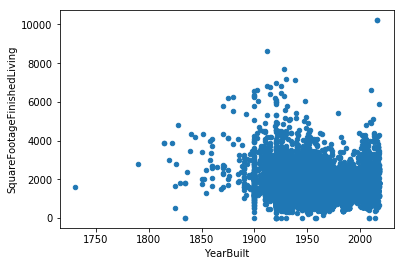

In [47]:
#Not really results, but explains the terrible performance
pddf_.plot.scatter(x='YearBuilt', y='SquareFootageFinishedLiving')

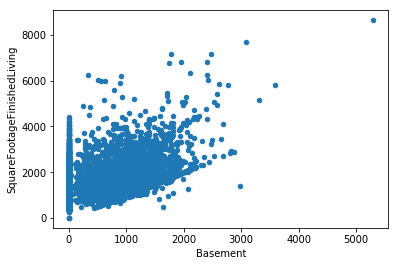

In [96]:
#Not really results, but explains the terrible performance
pddf_.plot.scatter(x='Basement', y='SquareFootageFinishedLiving')

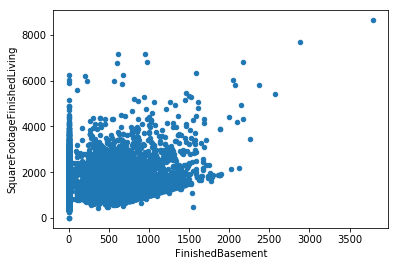

In [97]:
#Not really results, but explains the terrible performance
pddf_.plot.scatter(x='FinishedBasement', y='SquareFootageFinishedLiving')

## Epilogue: More vars

In [85]:
#Covert to sql df
pddf_s = pddf.loc[:, ["YearBuilt","SquareFootageFinishedLiving", "Basement", "FinishedBasement"]].dropna()
pddf_s.shape
sdf_wide = sqlc.createDataFrame(pddf_s)
print(sdf_wide.take(2))

[Row(YearBuilt=1967.0, SquareFootageFinishedLiving=1518.0, Basement=1518.0, FinishedBasement=759.0), Row(YearBuilt=1966.0, SquareFootageFinishedLiving=1138.0, Basement=1163.0, FinishedBasement=540.0)]


In [92]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ["YearBuilt", "Basement", "FinishedBasement"], outputCol = 'features')
v_df = vectorAssembler.transform(sdf_wide)
v_df = v_df.select(['features', "SquareFootageFinishedLiving"])
v_df.show(3)

+--------------------+---------------------------+
|            features|SquareFootageFinishedLiving|
+--------------------+---------------------------+
|[1967.0,1518.0,75...|                     1518.0|
|[1966.0,1163.0,54...|                     1138.0|
|[1967.0,1160.0,72...|                     1133.0|
+--------------------+---------------------------+
only showing top 3 rows



In [93]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [94]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='SquareFootageFinishedLiving', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.11474342299878845,0.5113935343088267,-0.16341000580021925]
Intercept: 961.8555268274384


In [95]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 669.835504
r2: 0.113822
